# Exercise 8 - Code

In [chapter 7](http://networksciencebook.com/chapter/7#measuring-degree) about *degree correlations* in Barabási's book you can find Figure 7.6 where for three networks the degree correlation is shown. Recapitulate these three plots.

Consider the three real-world datasets `collaboration.edgelist.txt`, `powergrid.edgelist.txt` and `metabolic.edgelist.txt`.
1. Compute the average next-nearest neighbor degrees for all occuring degrees. 
2. Plot them over the degrees. (as Fig. 7.6 suggests)
3. Fit the model $\langle k_{\text{nn}} \rangle  \propto k^\mu$ to the data and measure the exponent $\mu$. Use a linear fitting function here.
4. Do the same for BA and random networks and find $\mu$. (Average over some realizations)
4. Comment briefly the outcome for the latter.

In [30]:
import networkx as nx
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import binom
from matplotlib import pyplot as plt
from typing import Tuple, Union

plt.rcdefaults()
plt.style.use("seaborn-notebook")
plt.rc("figure", figsize=(11.2, 6.3))
plt.rc("font", size=12)
primary_color = "#7d3c96"
secondary_color = "#00f71e"

path = "../data/"

In [2]:
networks = {
    "Scientific Collaboration" : nx.read_edgelist(path + "collaboration.edgelist.txt"),
    "Power Grid": nx.read_edgelist(path + "powergrid.edgelist.txt"),
    "Metabolic Network" : nx.read_edgelist(path + "metabolic.edgelist.txt"),
}

In [25]:
def joint_dist(G: nx.Graph) -> np.ndarray:
    """calculates the joint degree distrubtion matrix of given graph"""

    max_deg = max(G.degree, key=lambda x: x[1])[1]
    joint_dist = np.zeros((max_deg+1, max_deg+1))

    for edge in G.edges:
        k1, k2 = tuple(dict(G.degree(edge)).values())
        joint_dist[k1, k2] += 1
        joint_dist[k2, k1] += 1

    return joint_dist / G.number_of_edges()


def P(j: int, k: int, dist: np.ndarray) -> float:
    """
    calculates the probability that a node with degree k
    has a neighbor with degree j for given joint distribution
    """
    q = np.sum(dist[:,k]) # probability that end of random edge has degree k
    q = np.where(q==0, 1, q) # sets 0s to 1s to not cause division by zero
    return dist[j, k] / q


def k_nn(G: nx.Graph) -> Tuple[np.ndarray, np.ndarray]:
    """
    calculates average nearest neighbor degree distribution
    and returns it with the degree range
    """
    J = joint_dist(G)
    max_deg = max(G.degree, key=lambda x: x[1])[1]
    x = np.arange(max_deg+1)
    y = np.array([np.sum([j * P(j,k,J) for j in x]) for k in x])
    return x[y != 0], y[y != 0]


def moment(G: nx.Graph, m: float = 1) -> float:
    """calculated the m-th moment of the degree distribution of the given graph"""
    return np.sum(np.power(np.array(list(dict(G.degree).values())), m)) / len(G)


def AKNND(G: nx.Graph) -> float:
    """calculates the average nearest neighbor degree for the given graph"""
    return moment(G, 2) / moment(G, 1)


def model(k: Union[float,np.ndarray], a: float = 1, mu: float = 1) -> float:
    """model to fit the nearest neighbor degree distribution"""
    return a * np.power(k, mu)

def main(G: nx.Graph, title: str = "", alpha: float = 1, legend: bool = False) -> float:
    xdata, ydata = k_nn(G)
    annd = AKNND(G)
    params, _ = curve_fit(model, xdata, ydata)
    x = np.logspace(np.log10(xdata[0]), np.log10(xdata[-1]), 101)
    y = model(x, *params)
    plt.loglog(xdata, ydata, "o", color=primary_color, alpha=alpha)
    plt.loglog(xdata, annd*np.ones(xdata.shape[0]), "k", label="random prediction", alpha=alpha)
    plt.loglog(x, y, color=secondary_color, label=rf"$\propto k^{{{params[1]:.3f}}}$", alpha=alpha)
    if legend:
        plt.legend()
    if title:
        plt.title(title)
    plt.xlabel(r"degree $k$")
    plt.ylabel(r"$k_{nn}(k)$")

    return params[1]

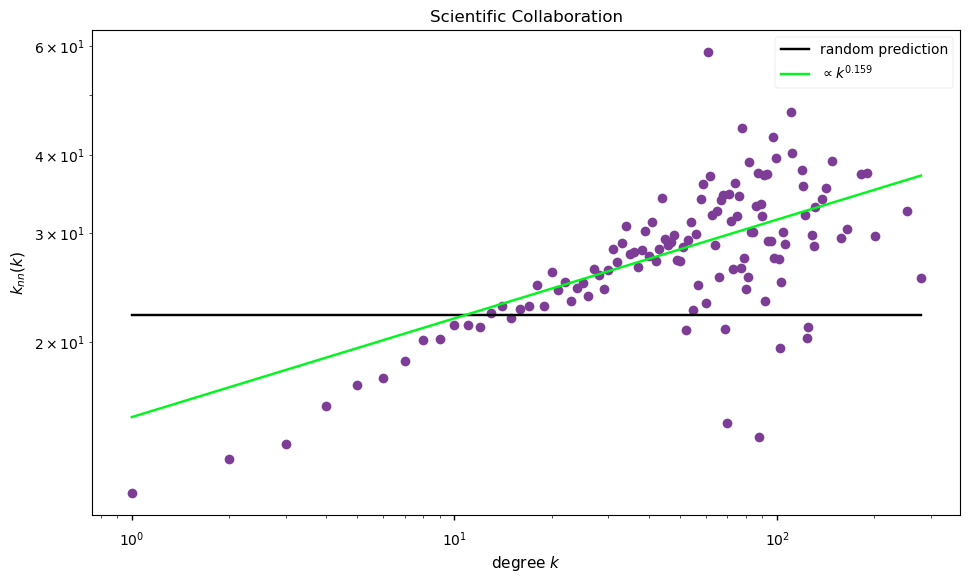

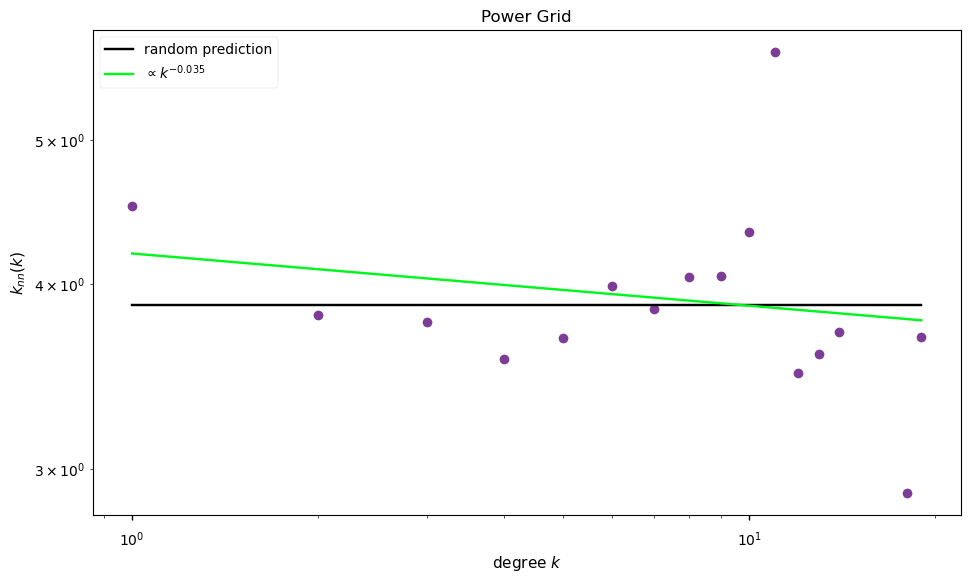

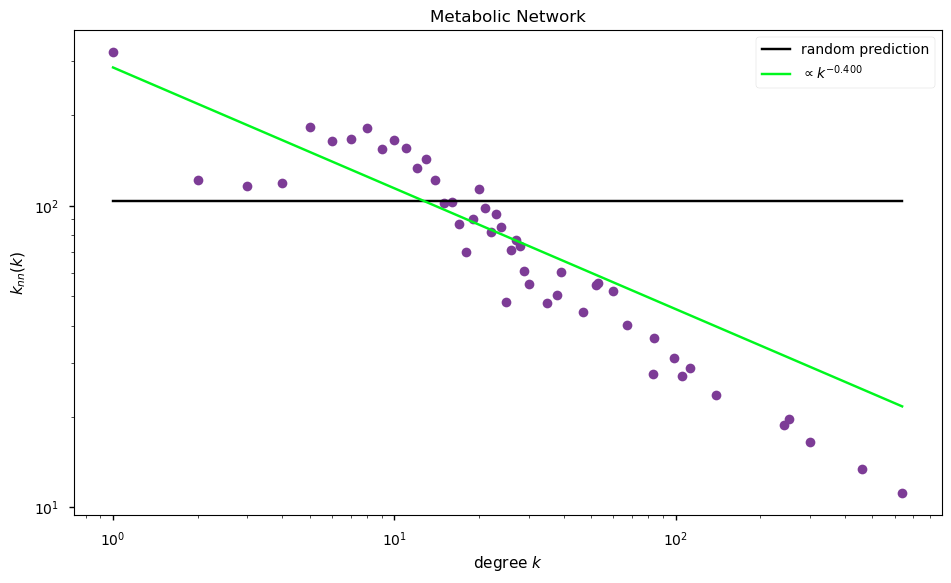

In [26]:
for name, network in networks.items():
    main(network, title=name, legend=True)
    plt.show()

The exponents differ slighty to that of Fig. 7.6 but this is probably due to the different curve fitting routine.

mean exponent: -0.2790811034021724


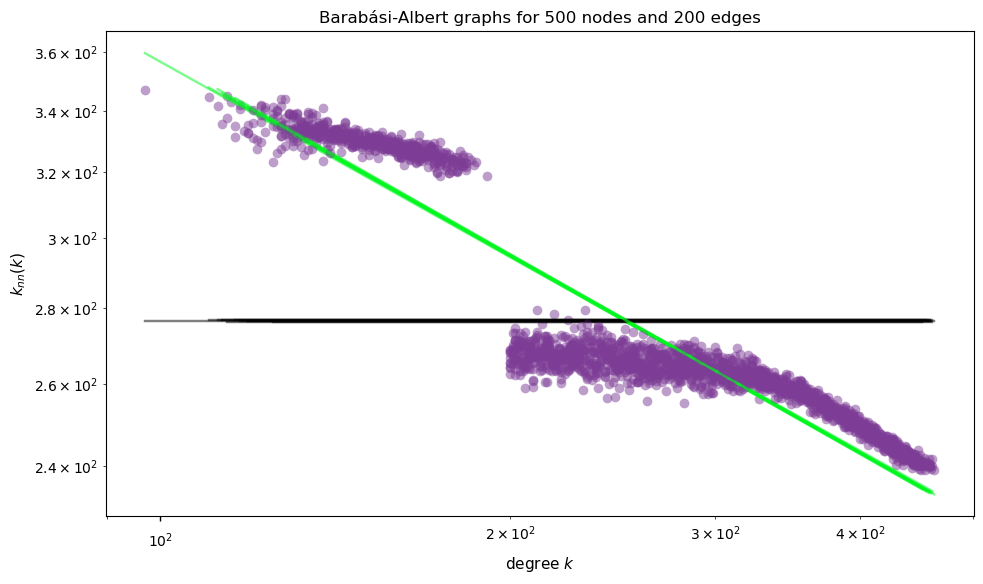

In [34]:
num_graphs = 10
N = 500
M = 200

mus = np.zeros(num_graphs)
for i, _ in enumerate(range(num_graphs)):
    G = nx.barabasi_albert_graph(N, M)
    mus[i] = main(G, title=f"Barabási-Albert graphs for {N} nodes and {M} edges", alpha=0.5)
print("mean exponent:", np.mean(mus))
plt.show()

In the Barabási-Albert graphs we see a negative exponent because of the preferential attachment a lot of low degree nodes connect to large hubs and therefore the disassortativity is expected.

mean exponent: -0.004146516360739893


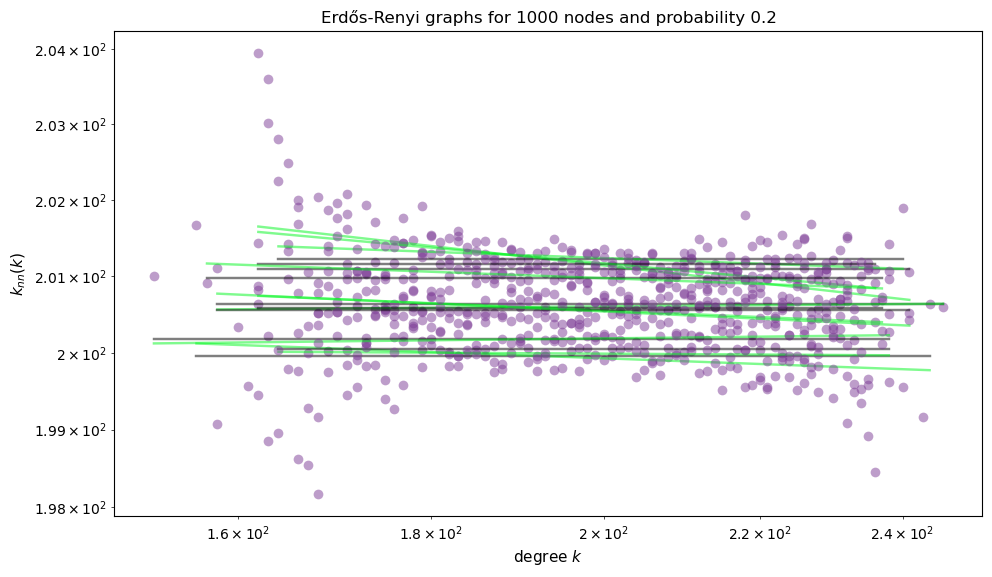

In [35]:
num_graphs = 10
N = 1000
p = 0.2

mus = np.zeros(num_graphs)
for i, _ in enumerate(range(num_graphs)):
    G = nx.erdos_renyi_graph(N, p)
    mus[i] = main(G, title=f"Erdős-Renyi graphs for {N} nodes and probability {p}", alpha=0.5)
print("mean exponent:", np.mean(mus))
plt.show()

As expected the Erdős-Renyi graphs are neutral because the edges are uniformly distributed and thus the degrees are uncorrelated.